In [128]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        x = torch.Tensor(self.data[index])
        y = torch.Tensor([self.labels[index]])
        return x, y

train_data = [[1, 2, 2, 0, 1, 1, 1, 231], [22, 12, 62, 35, 11, 61, 31, 1], [29, 13, 62, 35, 11, 31, 22, 29]]
train_labels = [1, 0, 0]

# 定义数据集和数据加载器
train_dataset = MyDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# 定义模型
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = torch.nn.Linear(8, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.sigmoid(out)
        return out

model = MyModel()

# 定义损失函数和优化器
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# 训练模型
num_epochs = 5000
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 打印损失函数
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# 预测数据标签
test_data = [[1, 1, 1, 0, 1, 2, 2, 88], [22, 12, 62, 35, 11, 61, 31, 2], [12, 13, 62, 35, 11, 31, 22, 12], [34, 12, 31, 3, 18, 22, 2, 41]]
for data in test_data:
    inputs = torch.Tensor(data)
    outputs = model(inputs)
    label = 1 if outputs.item() >= 0.5 else 0
    print('Data: {}, Label: {}'.format(data, label))


Epoch [1/5000], Loss: 0.0000
Epoch [2/5000], Loss: 0.0000
Epoch [3/5000], Loss: 0.0000
Epoch [4/5000], Loss: 0.0000
Epoch [5/5000], Loss: 0.0000
Epoch [6/5000], Loss: 0.0000
Epoch [7/5000], Loss: 0.0000
Epoch [8/5000], Loss: 0.0000
Epoch [9/5000], Loss: 0.0000
Epoch [10/5000], Loss: 0.0000
Epoch [11/5000], Loss: 0.0000
Epoch [12/5000], Loss: 0.0000
Epoch [13/5000], Loss: 0.0000
Epoch [14/5000], Loss: 0.0000
Epoch [15/5000], Loss: 0.0000
Epoch [16/5000], Loss: 0.0000
Epoch [17/5000], Loss: 0.0000
Epoch [18/5000], Loss: 0.0000
Epoch [19/5000], Loss: 0.0000
Epoch [20/5000], Loss: 0.0000
Epoch [21/5000], Loss: 0.0000
Epoch [22/5000], Loss: 0.0000
Epoch [23/5000], Loss: 0.0000
Epoch [24/5000], Loss: 0.0000
Epoch [25/5000], Loss: 0.0000
Epoch [26/5000], Loss: 0.0000
Epoch [27/5000], Loss: 0.0000
Epoch [28/5000], Loss: 0.0000
Epoch [29/5000], Loss: 0.0000
Epoch [30/5000], Loss: 0.0000
Epoch [31/5000], Loss: 0.0000
Epoch [32/5000], Loss: 0.0000
Epoch [33/5000], Loss: 0.0000
Epoch [34/5000], Lo

In [ ]:
import numpy as np
from sklearn.decomposition import NMF

# 生成一个随机的非负矩阵
V = np.array([[1, 2, 64], 
              [2, 2, 14], 
              [3, 3, 24], 
              [2, 2, 34], 
              [7, 3, 4]])

# 使用 sklearn 库中的 NMF 模型进行分解
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(V)
H = model.components_

# 计算重构误差
reconstruction_error = np.linalg.norm(V - W @ H)

# 打印结果
print("原始矩阵 V:\n", V)
print("分解后的矩阵 W:\n", W)
print("分解后的矩阵 H:\n", H)
print("重构误差:", reconstruction_error)


In [58]:
import anndata
import scanpy as sc
import numpy as np

In [56]:
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')

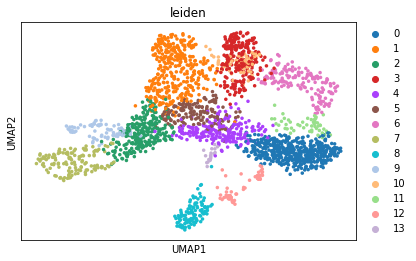

In [55]:
sc.pl.umap(adata_A, color=['leiden'])

In [125]:
adata_A.obs['x'] = adata_A.obsm['spatial'].T[0]
adata_A.obs['y'] = adata_A.obsm['spatial'].T[1]

In [110]:
a = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]],[[1, 1, 1], [1, 2, 1], [1, 1, 1]],[[1, 3, 1], [2, 2, 1], [1, 1, 1]]])
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
a * kernel


array([[[ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0]],

       [[ 0, -1,  0],
        [-1, 10, -1],
        [ 0, -1,  0]],

       [[ 0, -3,  0],
        [-2, 10, -1],
        [ 0, -1,  0]]])

In [123]:
cell = adata_A[128]
x = int(cell.obs['x'])
y = int(cell.obs['y'])
items = adata_A.obs[(adata_A.obs['x']>x-3) & 
                    (adata_A.obs['x']<x+3) &
                    (adata_A.obs['y']>y-3) & 
                    (adata_A.obs['y']<y+3)]
items

,col_0,leiden,x,y
AATGCACCAAGCAATG-1,1.0,8,19.0,97.0
AGATCGTGCATAAGAT-1,1.0,8,21.0,97.0
AGCTAGAAGCAGAAGT-1,1.0,8,21.0,99.0
ATCGGCAAGCAGTCCA-1,1.0,8,20.0,96.0
ATTCAGGACCTATTTC-1,1.0,8,20.0,98.0
CCTCGCGCGATATAGG-1,1.0,8,21.0,95.0
GAAATTAGCACGGATA-1,1.0,8,18.0,96.0
GGCTAAAGGGCGGGTC-1,1.0,8,19.0,99.0
GTCGTATTGGCGTACA-1,1.0,8,19.0,95.0
TAAAGCTGCAATAGGG-1,1.0,8,17.0,97.0


In [ ]:
def exp_convolution(adata, x_max, y_max):
    # the spatial coordinates should be in adata.obs
    kernel = np.array([
        [-1, -1, -1, -1, -1],
        [-1,  2,  2,  2, -1],
        [-1,  2,  8,  2, -1],
        [-1,  2,  2,  2, -1],
        [-1, -1, -1, -1, -1]
    ])
    for i in adata:
        x = adata[i].obs['x']
        y = adata[i].obs['y']
        surround_items = adata_A.obs[(adata_A.obs['x'] > x-3) &
                                     (adata_A.obs['x'] < x+3) &
                                     (adata_A.obs['y'] > y-3) &
                                     (adata_A.obs['y'] < y+3)]
        sub_adata = adata[surround_items.index]
        
        